# Project - Data Science

## Fullname (nickname): Chalermchon Wongsopa (Im)

## Project Topic: Condominium Selection

---
## Current Situation / Problem Statement

As an non capital city citizen that want to find the glory of work life, we have to move to Bangkok and go get a job!.

After saving some money for many years, we are thinking about selecting a place to live properly. 

But what can we afford? ..
Yes, It must be condominium.

Then, Which area is the best choice? 
How much should we spend our money preciously? 

Let's find it together!


### This project will take you all to the data-driven decision making for condominium selection based on it's sale location






## Objectives:

1. To decide the worth location to buy a condominium
2. To understand price distribution of condominium price by differernt districts

## Hypothesis-driven Questions:


1.   Average condominium selling prices are different by districts



## Environment Preparation

In [2]:
import pandas as pd
import numpy as np
import folium # map visualization
import matplotlib.pyplot as plt # visualization
%matplotlib inline
from geopy.geocoders import Nominatim # location caculation
from geopy.extra.rate_limiter import RateLimiter # bulk requests for geopy
from geopy.distance import distance
import numpy_financial as npf
import googlemaps
import seaborn as sns

## Dataset:

First two datasets were downloaded form [Bannia Organization](https://gobestimate.com/data).
<br/>Location dataset retrived by using Geopy libery.


1. Condominium selling price : Downloaded as csv from online source
2. Condominium rental price : Downloaded as csv from online source
3. District location (latitude, longitude) : Used geopy library

Sale price and rental price datasets were monthly aggregate data for median price per square metter, which number of aggregate sample represented in "total_listing" column

In [3]:
# read data

df_sell = pd.read_csv("./raw_data/opendata_median_price.csv") # sale price
df_rent = pd.read_csv("./raw_data/opendata_median_price_rent.csv") # rental price

In [4]:
# explore dataset - sale price

print(df_sell.shape)
df_sell.head()

(614, 11)


,row_number,transction_year,transction_month,listing_province_name_en,listing_province_name_th,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_asking_price_sqm
0,78,2019,7,BANGKOK,กรุงเทพมหานคร,ประเวศ,PRAWET,คอนโด,Condo,13,64971
1,342,2019,7,BANGKOK,กรุงเทพมหานคร,วัฒนา,VADHANA,คอนโด,Condo,128,173312
2,277,2020,12,BANGKOK,กรุงเทพมหานคร,จตุจักร,CHATUCHAK,คอนโด,Condo,23,109821
3,356,2021,1,BANGKOK,กรุงเทพมหานคร,พระโขนง,PHRA KHANONG,คอนโด,Condo,11,106412
4,598,2021,4,BANGKOK,กรุงเทพมหานคร,ราชเทวี,RATCHATHEWI,คอนโด,Condo,33,177486


In [5]:
# explore dataset - rental price

print(df_rent.shape)
df_rent.head()

(1550, 11)


,row_number,transction_year,transction_month,listing_province_name_th,listing_province_name_en,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_rent_price_sqm
0,1037,2021,11,กรุงเทพมหานคร,BANGKOK,บางซื่อ,BANG SUE,คอนโด,Condo,118,336
1,575,2021,10,กรุงเทพมหานคร,BANGKOK,สาทร,SATHON,คอนโด,Condo,265,561
2,143,2019,11,กรุงเทพมหานคร,BANGKOK,บางกะปิ,BANG KAPI,คอนโด,Condo,262,393
3,530,2021,8,กรุงเทพมหานคร,BANGKOK,สวนหลวง,PHATTHANAKAN,คอนโด,Condo,24,268
4,319,2021,12,นนทบุรี,NONTHABURI,เมืองนนทบุรี,MUEANG NONTHABURI,คอนโด,Condo,267,251


<br/>

#### Retrived districts latitude and longitude by sending district names to Geocoder function.

In [6]:
# create distinct BKK districts

df_location = df_sell[['listing_province_name_en', 'listing_district_name_en']].drop_duplicates()
df_location.columns = ['province', 'district']

In [7]:
# set nominatim to delay finding location = 1 sec
geocoder = RateLimiter(Nominatim(user_agent='get_loc').geocode, min_delay_seconds = 1)

# bulk requests for retriving Geocoder location
df_location['location'] = df_location.apply(lambda loc : geocoder(loc.district + ', ' + loc.province + ', thailand'), axis=1)

In [8]:
# get lat, long from location using apply+lambda

df_location['lat'] = df_location['location'].apply(lambda loc: loc.latitude if loc else None)
df_location['long'] = df_location['location'].apply(lambda loc: loc.longitude if loc else None)

In [9]:
# save data to directory

df_location.to_csv('./raw_data/dist_location.csv', index=False)

In [10]:
# check data looks

df_location.head()

,province,district,location,lat,long
0,BANGKOK,PRAWET,"(เขตประเวศ, กรุงเทพมหานคร, 10250, ประเทศไทย, (...",13.721360,100.697808
1,BANGKOK,VADHANA,"(เขตวัฒนา, กรุงเทพมหานคร, 10110, ประเทศไทย, (1...",13.742793,100.560501
2,BANGKOK,CHATUCHAK,"(เขตจตุจักร, กรุงเทพมหานคร, 10900, ประเทศไทย, ...",13.803036,100.550230
3,BANGKOK,PHRA KHANONG,"(เขตพระโขนง, กรุงเทพมหานคร, 10260, ประเทศไทย, ...",13.702364,100.601546
4,BANGKOK,RATCHATHEWI,"(เขตราชเทวี, กรุงเทพมหานคร, 10400, ประเทศไทย, ...",13.753223,100.531860


In [11]:
# check null value of retrived data

df_location.isnull().sum()

province    0
district    0
location    0
lat         0
long        0
dtype: int64


## Data Preparation (Data Cleaning):


1. Select desired data and rename columns
2. Find missing values

### Section 1 : Select desired data and rename columns

Sale price and rental price datasets had duplicate columns for location names in Thai and English languages. And some variable names were not easy to understand.

In [12]:
# explore dataset - sale price

print(df_sell.shape)
df_sell.head()

(614, 11)


,row_number,transction_year,transction_month,listing_province_name_en,listing_province_name_th,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_asking_price_sqm
0,78,2019,7,BANGKOK,กรุงเทพมหานคร,ประเวศ,PRAWET,คอนโด,Condo,13,64971
1,342,2019,7,BANGKOK,กรุงเทพมหานคร,วัฒนา,VADHANA,คอนโด,Condo,128,173312
2,277,2020,12,BANGKOK,กรุงเทพมหานคร,จตุจักร,CHATUCHAK,คอนโด,Condo,23,109821
3,356,2021,1,BANGKOK,กรุงเทพมหานคร,พระโขนง,PHRA KHANONG,คอนโด,Condo,11,106412
4,598,2021,4,BANGKOK,กรุงเทพมหานคร,ราชเทวี,RATCHATHEWI,คอนโด,Condo,33,177486


In [13]:
# explore dataset - rental price

print(df_rent.shape)
df_rent.head()

(1550, 11)


,row_number,transction_year,transction_month,listing_province_name_th,listing_province_name_en,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_rent_price_sqm
0,1037,2021,11,กรุงเทพมหานคร,BANGKOK,บางซื่อ,BANG SUE,คอนโด,Condo,118,336
1,575,2021,10,กรุงเทพมหานคร,BANGKOK,สาทร,SATHON,คอนโด,Condo,265,561
2,143,2019,11,กรุงเทพมหานคร,BANGKOK,บางกะปิ,BANG KAPI,คอนโด,Condo,262,393
3,530,2021,8,กรุงเทพมหานคร,BANGKOK,สวนหลวง,PHATTHANAKAN,คอนโด,Condo,24,268
4,319,2021,12,นนทบุรี,NONTHABURI,เมืองนนทบุรี,MUEANG NONTHABURI,คอนโด,Condo,267,251


In [14]:
# drop unnecessary columns

df_sell.drop(['row_number', 'listing_province_name_th', 'listing_district_name_th', 'project_propertytype_name_th'],
             axis=1,
             inplace=True
            )

df_rent.drop(['row_number', 'listing_province_name_th', 'listing_district_name_th', 'project_propertytype_name_th'],
             axis=1,
             inplace=True
            )

In [15]:
# rename columns

df_sell.columns = ['year', 'month', 'province', 'district', 'prop_type', 'n', 'sell_price_sqm']
df_rent.columns = ['year', 'month', 'province', 'district', 'prop_type', 'n', 'rent_price_sqm']

In [16]:
df_sell.head()

,year,month,province,district,prop_type,n,sell_price_sqm
0,2019,7,BANGKOK,PRAWET,Condo,13,64971
1,2019,7,BANGKOK,VADHANA,Condo,128,173312
2,2020,12,BANGKOK,CHATUCHAK,Condo,23,109821
3,2021,1,BANGKOK,PHRA KHANONG,Condo,11,106412
4,2021,4,BANGKOK,RATCHATHEWI,Condo,33,177486


In [17]:
df_rent.head()

,year,month,province,district,prop_type,n,rent_price_sqm
0,2021,11,BANGKOK,BANG SUE,Condo,118,336
1,2021,10,BANGKOK,SATHON,Condo,265,561
2,2019,11,BANGKOK,BANG KAPI,Condo,262,393
3,2021,8,BANGKOK,PHATTHANAKAN,Condo,24,268
4,2021,12,NONTHABURI,MUEANG NONTHABURI,Condo,267,251


In [18]:
# create categorical data exploratory function

def eda_unique(data, *cols):
    """
    Print information about unique value in given variables
    data: DataFrame-like object
    cols: Arbitrary arguments for columns that interested to explore
    """
    for col in cols:
        print(f'\n---- Unique Values Exploration ----\n')
        print('Name:', col)
        print('Type:', data[col].dtypes)
        print('Value:', data[col].unique(), '\nN unique:', data[col].nunique())
        print("\n------------------------------")

### Explore categorical data to select interested fields
#### Sale price: 
Sale price dataset contains 3 years, which are 2019, 2020, 2021, in 3 provinces, Bangkok, Nonthaburi, Samut Prakan with total 38 districts. <br/><br/>
Sale price dataset from 2021 should be the most updated data that we can use but after exploring 2021 dataset, there are only 16 districts were recorded that significantly less than other years recorded districts.  
#### Rental price:
Rental price data set has 4 years, which are 2019 - 2022, in 5 provinces with 54 total districts.

<br/>
Since this analysis is focus on condominium property type, other properties are excluded to a dataframe.

In [19]:
# explore data unique value - sale price data

eda_unique(df_sell, 'year', 'month', 'province', 'district', 'prop_type')


---- Unique Values Exploration ----

Name: year
Type: int64
Value: [2019 2020 2021] 
N unique: 3

------------------------------

---- Unique Values Exploration ----

Name: month
Type: int64
Value: [ 7 12  1  4 10  6  8  2 11  3  5  9] 
N unique: 12

------------------------------

---- Unique Values Exploration ----

Name: province
Type: object
Value: ['BANGKOK' 'NONTHABURI' 'SAMUT PRAKAN' 'PATHUM THANI'] 
N unique: 4

------------------------------

---- Unique Values Exploration ----

Name: district
Type: object
Value: ['PRAWET' 'VADHANA' 'CHATUCHAK' 'PHRA KHANONG' 'RATCHATHEWI' 'HUAI KHWANG'
 'BANG RAK' 'LAK SI' 'THON BURI' 'PAK KRET' 'MUEANG NONTHABURI' 'YAN NAWA'
 'SUAN LUANG' 'BANG PHLI' 'BANG NA' 'LAM LUK KA' 'KHLONG TOEI' 'BANG KAPI'
 'DIN DAENG' 'BANG KHAE' 'RAT BURANA' 'SATHON' 'BANG SUE' 'BUENG KUM'
 'PHASI CHAROEN' 'KHLONG SAN' 'PATHUM WAN' 'MUEANG SAMUT PRAKAN'
 'BANG KHO LAEM' 'LAT PHRAO' 'PHAYA THAI' 'BANG PHLAT' 'MIN BURI'
 'BANGKOK NOI' 'CHOM THONG' 'BANG KHEN' 'KHLO

In [20]:
# explore newest year's (2021) sale price data

eda_unique(df_sell[df_sell.year == 2021], 'province', 'district')


---- Unique Values Exploration ----

Name: province
Type: object
Value: ['BANGKOK'] 
N unique: 1

------------------------------

---- Unique Values Exploration ----

Name: district
Type: object
Value: ['PHRA KHANONG' 'RATCHATHEWI' 'KHLONG TOEI' 'VADHANA' 'BANG RAK'
 'CHATUCHAK' 'BANG NA' 'KHLONG SAN' 'HUAI KHWANG' 'BANGKOK NOI'
 'PHAYA THAI' 'PATHUM WAN' 'PRAWET' 'DIN DAENG' 'CHOM THONG' 'SATHON'] 
N unique: 16

------------------------------


In [21]:
# explore data unique value - rental price

eda_unique(df_rent, 'year', 'month', 'province', 'district', 'prop_type')


---- Unique Values Exploration ----

Name: year
Type: int64
Value: [2021 2019 2020 2022] 
N unique: 4

------------------------------

---- Unique Values Exploration ----

Name: month
Type: int64
Value: [11 10  8 12  1  6  2  3  4  7  9  5] 
N unique: 12

------------------------------

---- Unique Values Exploration ----

Name: province
Type: object
Value: ['BANGKOK' 'NONTHABURI' 'PATHUM THANI' 'SAMUT PRAKAN' 'NAKHON PATHOM'] 
N unique: 5

------------------------------

---- Unique Values Exploration ----

Name: district
Type: object
Value: ['BANG SUE' 'SATHON' 'BANG KAPI' 'PHATTHANAKAN' 'MUEANG NONTHABURI'
 'KHLONG SAN' 'BANGKOK YAI' 'BANG RAK' 'BANG KHO LAEM' 'BANGKOK NOI'
 'LAT PHRAO' 'CHATUCHAK' 'BANG KHAE' 'KHLONG LUANG' 'BANG PHLAT'
 'CHOM THONG' 'RAT BURANA' 'SUAN LUANG' 'BANG BUA THONG' 'DIN DAENG'
 'HUAI KHWANG' 'SAI MAI' 'YAN NAWA' 'BANG PHLI' 'PHRA PRADAENG'
 'PHRA KHANONG' 'RATCHATHEWI' 'KHLONG TOEI' 'BANG NA' 'KHAN NA YAO'
 'MUEANG SAMUT PRAKAN' 'WANG THONGLANG' 'BANG K

In [22]:
# select only condominium property type

df_sell = df_sell[df_sell['prop_type'] == 'Condo']
df_rent = df_rent[df_rent['prop_type'] == 'Condo']

### Section 2 : Check missing values

In [23]:
# check missing values

df_sell.isnull().sum()

year              0
month             0
province          0
district          0
prop_type         0
n                 0
sell_price_sqm    0
dtype: int64

In [24]:
df_rent.isnull().sum()

year              0
month             0
province          0
district          0
prop_type         0
n                 0
rent_price_sqm    0
dtype: int64

## Exploratory Data Analysis (EDA):

1.  EDA to select data
2.  Analysis to select condominium for living purpose
3.  Analysis to select condominium for investment purpose

#### Section 1 : EDA to select data
<br/>
After knowing that 2021 sale price data have fewer recorded districs, this section aims to exlpore that addition of previous years data could be better representative of condominium price over districts.

<br/>

Number of codominium sales obviously decreased over years after 2019 from 26,653 sale posts to 3,111 sale posts in 2021 due to Covid-19 situation but yearly avrage prices are more stable that its number of sales.

<br/>

We could imply that combining 3 years average for condominium prices would not have strongly effect from price fluctuation.

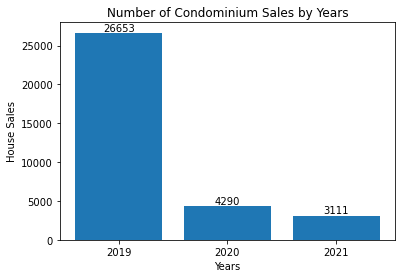

In [25]:
# create chart : number of house sales by year.

x = [str(x) for x in list(df_sell.groupby('year').sum().index)]
y = df_sell.groupby('year').sum().n

fig, ax = plt.subplots()

bars = plt.bar(x, y)
plt.title('Number of Condominium Sales by Years')
plt.xlabel('Years')
plt.ylabel('House Sales')
ax.bar_label(bars)

plt.show()


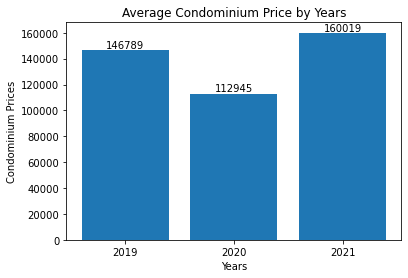

In [26]:
# Avg.salse price by year

x = [str(x) for x in list(df_sell.groupby('year').sum().index)]
y = df_sell.groupby('year').apply(lambda x : np.average(x.sell_price_sqm, weights=x.n))

fig, ax = plt.subplots()

bars = plt.bar(x, y)
plt.title('Average Condominium Price by Years')
plt.xlabel('Years')
plt.ylabel('Condominium Prices')
ax.bar_label(bars)

plt.show()


The price distribution from histogram looks like normal distribution but its skewness shows that condominium prices data might have outliers on the right-hand side. However, it is litteraly known that property prices depend on its location.

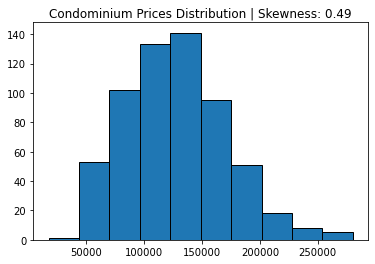

In [27]:
# create saleprice distribution / skewnwss

plt.hist(df_sell['sell_price_sqm'], edgecolor='black')
plt.title(f'Condominium Prices Distribution | Skewness: {df_sell.sell_price_sqm.skew().round(2)}')
plt.show()

#### Section 2 : Analysis to select condominium for living purpose

The analysis was assumed to identify reasonable condominium price for 30 square meters room size.

In [28]:
# create aggregate dataframe based on weighted average sale price by district 

df_sell_dist = pd.DataFrame(df_sell.groupby('district').apply(lambda x : np.average(x.sell_price_sqm, weights=x.n)),
            columns=['sell_price_sqm']).reset_index()

# merge number of salse by district
df_sell_dist = pd.merge(df_sell_dist, pd.DataFrame(df_sell.groupby('district').sum().n), on='district', how='left')


# merge with locaiton data
df_sell_dist = pd.merge(df_sell_dist, df_location, on='district', how='left')

# esitmate price for 30 sqm room size

df_sell_dist['sell_price_30sqm'] = df_sell_dist.sell_price_sqm * 30 / 1000000

In [29]:
# check dataset

df_sell_dist.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330
1,BANG KAPI,96240.100352,568,BANGKOK,"(เขตบางกะปิ, กรุงเทพมหานคร, ประเทศไทย, (13.764...",13.764000,100.644808,2.887203
2,BANG KHAE,81168.653061,49,BANGKOK,"(เขตบางแค, กรุงเทพมหานคร, 10160, ประเทศไทย, (1...",13.710743,100.420823,2.435060
3,BANG KHEN,79196.206349,126,BANGKOK,"(บางเขน, ถนนกำแพงเพชร 6, แขวงลาดยาว, เขตจตุจัก...",13.847000,100.560620,2.375886
4,BANG KHO LAEM,126766.478723,94,BANGKOK,"(2351 Soi Charoen Krung 91, Khwaeng Wat Phraya...",13.704162,100.505343,3.802994


<br/>
Top most expensive condominiums are located in Bang Rak, Pathum Wan, Ratchathewi with estimated price of 5.81, 5.23, and 5.06 million baht respectively for 30 sqm. room size.

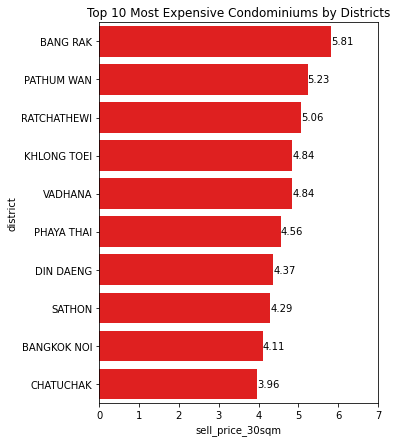

In [30]:
# create top 10 most expensive districts 

x = df_sell_dist.sort_values(by='sell_price_30sqm', ascending=False)['sell_price_30sqm'][:10].round(2)
y = df_sell_dist.sort_values(by='sell_price_30sqm', ascending=False)['district'][:10]

plt.figure(figsize=(5,7))
bar = sns.barplot(x=x, y=y, color='r')
bar.bar_label(bar.containers[0])
bar.set(xlim=(0, 7))
plt.title("Top 10 Most Expensive Condominiums by Districts");

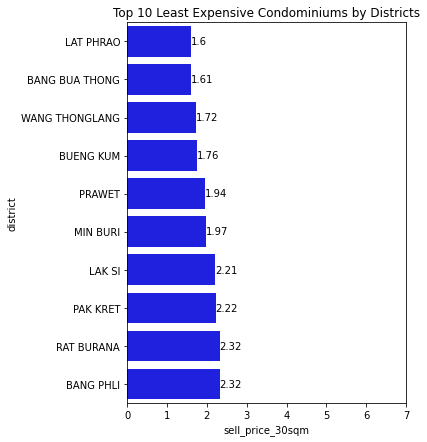

In [31]:
# create top 10 least expensive districts 

x = df_sell_dist.sort_values(by='sell_price_30sqm', ascending=True)['sell_price_30sqm'][:10].round(2)
y = df_sell_dist.sort_values(by='sell_price_30sqm', ascending=True)['district'][:10]

plt.figure(figsize=(5,7))
bar = sns.barplot(x=x, y=y, color='b')
bar.bar_label(bar.containers[0])
bar.set(xlim=(0, 7))
plt.title("Top 10 Least Expensive Condominiums by Districts");

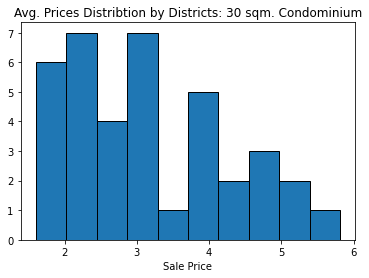

In [75]:
# create sale prices distribution by districts to find the price range.

plt.hist(df_sell_dist.sell_price_30sqm, edgecolor='black')
plt.xlabel("Sale Price")
plt.title('Avg. Prices Distribtion by Districts: 30 sqm. Condominium');

In [70]:
# color data by range of selling price to create map.

def price_color(price):
    """
    Return color by price range.
    < 2 MB : Light green
    2-3 MB : Dark green
    3-4 MB : Orange
    4-5 MB : Red
    5-6 MB : Dark red
    """
    if price < 2:
        return 'lightgreen'
    elif price < 3:
        return 'darkgreen'
    elif price < 4:
        return 'orange'
    elif price < 5:
        return 'red'
    elif price < 6:
        return 'darkred'
    
df_sell_dist['sell_color_code'] = df_sell_dist.sell_price_30sqm.apply(price_color)

In [96]:
# Get Bangkok location to locate latitude and longtitude to map.
loc_bangkok = geocoder('Bangkok')

# Get Siam Square location to observe codominium prices around the location.
loc_siam = geocoder('siam square')

In [160]:
# create bkk map
bk_map = folium.Map(
    location = [loc_bangkok.latitude, loc_bangkok.longitude],
    zoom_start = 12,
    tiles='cartodbpositron',
)

# plot district location
for (index, row) in df_sell_dist.iterrows():
    iframe = folium.IFrame('District name: ' + row.loc['district'] + '<br>' * 2+ \
                           'AVG. Price: ' + str(round(row.loc['sell_price_30sqm'],2)) + ' MB')
    popup = folium.Popup(iframe, min_width=200, max_width=200)
    folium.Marker(location = [row.loc['lat'], row.loc['long']],
                  popup = popup,
                  icon = folium.Icon(color=row.loc['sell_color_code'])
                 ).add_to(bk_map)

# circle Siam Square location for 5 km. of radius to observe condominium prices around the location. 
folium.Circle(location = [loc_siam.latitude, loc_siam.longitude],
             radius = 5000,
             color = 'pink',
             fill = True,
             fill_color = 'red').add_to(bk_map)


#### Map Visualization
The map below shows average condominium price across districts by using color of marks,
which colored from light green to dark red by its price range respectively.

After circled one of the most popular area in Thailand, which is Siam Square, for 5 km., <br/>
The map can reveal that the top 3 most expensive condominium price districts are located inside, which represented by dark red color marks.

Moreover, other high average price districts are also in the circle.

In [161]:
bk_map

In [167]:
# Calculate distance from Siam Square to each district.

df_sell_dist['siam_distance'] = df_sell_dist.apply(lambda loc : 
                                                   distance((loc_siam.latitude, loc_siam.longitude), (loc.lat, loc.long)).km,
                                                  axis = 1)

Plotting avearage sale prices vs. distance to Siam Square could imply that closer to Siam Square district will be more expensive than other area.

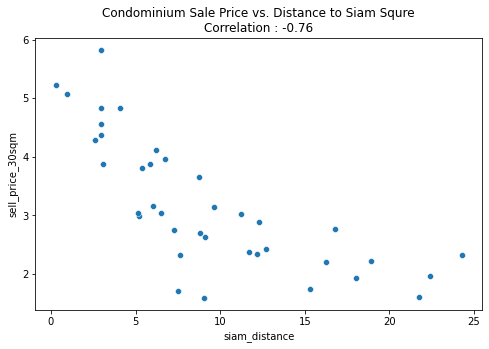

In [190]:
# Calculate correlation.
corr = df_sell_dist[['siam_distance', 'sell_price_30sqm']].corr()['siam_distance']['sell_price_30sqm'].round(2)

# Plot distance to Siam Square to show and average price to show its correlation.

plt.figure(figsize=(8,5))
plt.title(f'Condominium Sale Price vs. Distance to Siam Squre\nCorrelation : {corr}')
sns.scatterplot(data=df_sell_dist, x='siam_distance', y='sell_price_30sqm');

#### Add other information to each districts.

To understand more about condominium prices across districts, other information must be taken into account, such as
<br/>monthly mortgage payment, distance to interested area, monthly transportation cost.

In [40]:
# calculate distance to working area
# get True Digital Park location

true_loc = geocoder('True digital park 101')

In [165]:
# Calculate monthly mortgage payment and add to df_sell_dst
# Based on 
#     20 years of payment periods
#     6.24% yearly interest rate

df_sell_dist['pmt'] = df_sell_dist.apply(
    lambda row : -round(npf.pmt(0.0624/12, 20*12, row.sell_price_30sqm*1000000), 2), axis=1)

In [41]:
# add distance to location dataframe

df_location['true_distance'] = df_location.apply(lambda loc : distance((true_loc.latitude, true_loc.longitude), (loc.lat, loc.long)).km, axis=1)

In [42]:
df_location.head()

,province,district,location,lat,long,true_distance
0,BANGKOK,PRAWET,"(เขตประเวศ, กรุงเทพมหานคร, 10250, ประเทศไทย, (...",13.721360,100.697808,10.159732
1,BANGKOK,VADHANA,"(เขตวัฒนา, กรุงเทพมหานคร, 10110, ประเทศไทย, (1...",13.742793,100.560501,8.382572
2,BANGKOK,CHATUCHAK,"(เขตจตุจักร, กรุงเทพมหานคร, 10900, ประเทศไทย, ...",13.803036,100.550230,14.577390
3,BANGKOK,PHRA KHANONG,"(เขตพระโขนง, กรุงเทพมหานคร, 10260, ประเทศไทย, ...",13.702364,100.601546,2.136037
4,BANGKOK,RATCHATHEWI,"(เขตราชเทวี, กรุงเทพมหานคร, 10400, ประเทศไทย, ...",13.753223,100.531860,11.395239


In [43]:
# create transportation cost calculation function (TDA vs district)
# return monthly average cost
# assumed 260 working day in 2022 - 19 public holidays = 241 days/year -> 20 days/months
# engine fuel consumtion = 15 km / 1 litter
# fuel price based on E20 price ~ 37 THB / 1 litter

def tran_cost(distance, days=20, fuel_consum=15, fuel_price=37, round_trip=True):
    if round_trip == True:
        return distance * days / fuel_consum * fuel_price * 2
    else:
        return distance * days / fuel_consum * fuel_price

In [44]:
df_location['true_transcost'] = df_location.true_distance.apply(tran_cost)

In [45]:
df_location.head()

,province,district,location,lat,long,true_distance,true_transcost
0,BANGKOK,PRAWET,"(เขตประเวศ, กรุงเทพมหานคร, 10250, ประเทศไทย, (...",13.721360,100.697808,10.159732,1002.426909
1,BANGKOK,VADHANA,"(เขตวัฒนา, กรุงเทพมหานคร, 10110, ประเทศไทย, (1...",13.742793,100.560501,8.382572,827.080408
2,BANGKOK,CHATUCHAK,"(เขตจตุจักร, กรุงเทพมหานคร, 10900, ประเทศไทย, ...",13.803036,100.550230,14.577390,1438.302438
3,BANGKOK,PHRA KHANONG,"(เขตพระโขนง, กรุงเทพมหานคร, 10260, ประเทศไทย, ...",13.702364,100.601546,2.136037,210.755666
4,BANGKOK,RATCHATHEWI,"(เขตราชเทวี, กรุงเทพมหานคร, 10400, ประเทศไทย, ...",13.753223,100.531860,11.395239,1124.330215


In [46]:
df_sell_dist.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code,pmt
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen,11746.37
1,BANG KAPI,96240.100352,568,BANGKOK,"(เขตบางกะปิ, กรุงเทพมหานคร, ประเทศไทย, (13.764...",13.764000,100.644808,2.887203,darkgreen,21086.56
2,BANG KHAE,81168.653061,49,BANGKOK,"(เขตบางแค, กรุงเทพมหานคร, 10160, ประเทศไทย, (1...",13.710743,100.420823,2.435060,darkgreen,17784.35
3,BANG KHEN,79196.206349,126,BANGKOK,"(บางเขน, ถนนกำแพงเพชร 6, แขวงลาดยาว, เขตจตุจัก...",13.847000,100.560620,2.375886,darkgreen,17352.18
4,BANG KHO LAEM,126766.478723,94,BANGKOK,"(2351 Soi Charoen Krung 91, Khwaeng Wat Phraya...",13.704162,100.505343,3.802994,orange,27775.00


In [47]:
df_sell_dist = pd.merge(df_sell_dist, df_location[['district', 'true_distance', 'true_transcost']], on='district', how='left')

In [48]:
df_sell_dist['monthly_exp'] = df_sell_dist['pmt'] + df_sell_dist['true_transcost']

In [49]:
df_sell_dist.sort_values(by='monthly_exp').head(5)

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code,pmt,true_distance,true_transcost,monthly_exp
20,LAT PHRAO,53370.444444,36,BANGKOK,"(เขตลาดพร้าว, กรุงเทพมหานคร, 10230, ประเทศไทย,...",13.803679,100.590874,1.601113,lightgreen,11693.66,13.251591,1307.490354,13001.150354
36,WANG THONGLANG,57251.750000,36,BANGKOK,"(เขตวังทองหลาง, กรุงเทพมหานคร, 10310, ประเทศไท...",13.767821,100.598274,1.717553,lightgreen,12544.07,9.207322,908.455807,13452.525807
12,BUENG KUM,58505.024390,41,BANGKOK,"(เขตบึงกุ่ม, กรุงเทพมหานคร, ประเทศไทย, (13.785...",13.785357,100.668631,1.755151,lightgreen,12818.66,12.660766,1249.195601,14067.855601
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen,11746.37,31.786322,3136.250464,14882.620464
29,PRAWET,64662.887931,116,BANGKOK,"(เขตประเวศ, กรุงเทพมหานคร, 10250, ประเทศไทย, (...",13.721360,100.697808,1.939887,lightgreen,14167.87,10.159732,1002.426909,15170.296909


In [50]:
# filter <= 10 km distance to TDA

df_near_true_dist = df_sell_dist[df_sell_dist['true_distance'] <= 10].sort_values(by='monthly_exp')

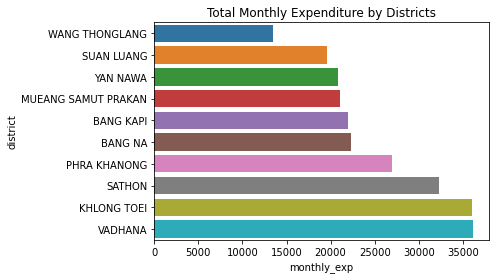

In [51]:
x = df_near_true_dist.monthly_exp
y = df_near_true_dist.district

sns.barplot(x=x, y=y)
plt.title("Total Monthly Expenditure by Districts")
plt.show()

In [52]:
# create bkk map
bk_map_near_true = folium.Map(
    location = [loc_bangkok.latitude, loc_bangkok.longitude],
    zoom_start = 12,
    tiles='cartodbpositron',
)

# plot district location
for (index, row) in df_near_true_dist.iterrows():
    iframe = folium.IFrame('District name: ' + row.loc['district'] + '<br>' * 2+ 
                           'AVG. Price: ' + str(round(row.loc['sell_price_30sqm'],2)) + ' MB' +
                          '<br>' + 'Monthly installment: ' + str('{:,.2f}'.format(round(row.loc['pmt'],2))) + ' THB' + 
                          '<br>' + 'Transportation cost: ' + str('{:,.2f}'.format(round(row.loc['true_transcost'],2))) + ' THB' +
                           '<br>' + 'Total monthly expenditure: ' + str('{:,.2f}'.format(round(row.loc['monthly_exp'],2))) + ' THB'
                          )
    popup = folium.Popup(iframe, min_width=300, max_width=300)
    folium.Marker(location = [row.loc['lat'], row.loc['long']],
                  popup = popup,
                  icon = folium.Icon(color=row.loc['sell_color_code'])
                 ).add_to(bk_map_near_true)

# add true digital park to map
folium.Marker(location = [true_loc.latitude, true_loc.longitude],
              icon = folium.Icon(color='blue')
             ).add_to(bk_map_near_true)

In [53]:
bk_map_near_true

#### Section 3 : Condominuims for rental purpose

In [54]:
df_rent.year.unique()

array([2021, 2019, 2020, 2022], dtype=int64)

In [55]:
df_rent[df_rent.year != 2022].district.nunique()

54

In [56]:
df_rent.head()

,year,month,province,district,prop_type,n,rent_price_sqm
0,2021,11,BANGKOK,BANG SUE,Condo,118,336
1,2021,10,BANGKOK,SATHON,Condo,265,561
2,2019,11,BANGKOK,BANG KAPI,Condo,262,393
3,2021,8,BANGKOK,PHATTHANAKAN,Condo,24,268
4,2021,12,NONTHABURI,MUEANG NONTHABURI,Condo,267,251


In [57]:
df_rent_dist = pd.DataFrame(df_rent[df_rent.year != 2022].groupby('district').apply(
    lambda x : np.average(x.rent_price_sqm, weights=x.n)), columns=['rent_price_sqm']).reset_index()

In [58]:
df_rent_dist['rent_price_30sqm'] = df_rent_dist['rent_price_sqm'] * 30 

In [59]:
df_rent_dist.sort_values(by='rent_price_sqm', ascending=False).head()

,district,rent_price_sqm,rent_price_30sqm
36,PATHUM WAN,741.500845,22245.025338
51,VADHANA,641.661337,19249.840122
11,BANG RAK,633.014461,18990.433826
26,KHLONG TOEI,626.650585,18799.517551
47,SATHON,573.575438,17207.263144


In [60]:
df_sell_dist = pd.merge(df_sell_dist, df_rent_dist[['district', 'rent_price_30sqm']], on='district', how='left')

In [61]:
df_sell_dist.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code,pmt,true_distance,true_transcost,monthly_exp,rent_price_30sqm
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen,11746.37,31.786322,3136.250464,14882.620464,7015.485782
1,BANG KAPI,96240.100352,568,BANGKOK,"(เขตบางกะปิ, กรุงเทพมหานคร, ประเทศไทย, (13.764...",13.764000,100.644808,2.887203,darkgreen,21086.56,9.402288,927.692394,22014.252394,9995.551011
2,BANG KHAE,81168.653061,49,BANGKOK,"(เขตบางแค, กรุงเทพมหานคร, 10160, ประเทศไทย, (1...",13.710743,100.420823,2.435060,darkgreen,17784.35,20.792558,2051.532359,19835.882359,8381.250000
3,BANG KHEN,79196.206349,126,BANGKOK,"(บางเขน, ถนนกำแพงเพชร 6, แขวงลาดยาว, เขตจตุจัก...",13.847000,100.560620,2.375886,darkgreen,17352.18,18.681258,1843.217481,19195.397481,8684.242567
4,BANG KHO LAEM,126766.478723,94,BANGKOK,"(2351 Soi Charoen Krung 91, Khwaeng Wat Phraya...",13.704162,100.505343,3.802994,orange,27775.00,11.645598,1149.032384,28924.032384,12107.084469


In [62]:
df_sell_dist['rent_pay'] = df_sell_dist['rent_price_30sqm'] / df_sell_dist['pmt']

In [63]:
# create top return/installment
df_top_return = df_sell_dist.sort_values(by='rent_pay', ascending=False).head(10)

In [64]:
df_top_return.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code,pmt,true_distance,true_transcost,monthly_exp,rent_price_30sqm,rent_pay
20,LAT PHRAO,53370.444444,36,BANGKOK,"(เขตลาดพร้าว, กรุงเทพมหานคร, 10230, ประเทศไทย,...",13.803679,100.590874,1.601113,lightgreen,11693.66,13.251591,1307.490354,13001.150354,9493.080357,0.811814
36,WANG THONGLANG,57251.750000,36,BANGKOK,"(เขตวังทองหลาง, กรุงเทพมหานคร, 10310, ประเทศไท...",13.767821,100.598274,1.717553,lightgreen,12544.07,9.207322,908.455807,13452.525807,8751.611374,0.697669
21,MIN BURI,65595.000000,12,BANGKOK,"(แขวงมีนบุรี, เขตมีนบุรี, กรุงเทพมหานคร, 10510...",13.812467,100.728348,1.967850,lightgreen,14372.10,18.902316,1865.028492,16237.128492,9017.352941,0.627421
7,BANG PHLI,77397.328767,73,SAMUT PRAKAN,"(เทศบาลตำบลบางพลี, อำเภอบางพลี, จังหวัดสมุทรปร...",13.607126,100.707883,2.321920,darkgreen,16958.04,13.584029,1340.290817,18298.330817,10367.512847,0.611363
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen,11746.37,31.786322,3136.250464,14882.620464,7015.485782,0.597247


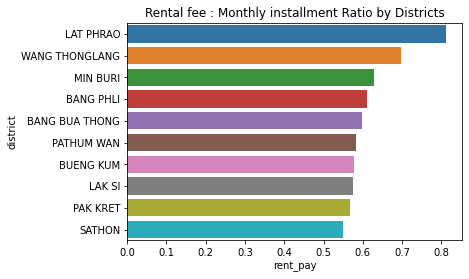

In [65]:
x = df_top_return.rent_pay
y = df_top_return.district

sns.barplot(x=x, y=y)
plt.title("Rental fee : Monthly installment Ratio by Districts")
plt.show()

In [66]:
# create bkk map
bk_map_rent = folium.Map(
    location = [loc_bangkok.latitude, loc_bangkok.longitude],
    zoom_start = 12,
    tiles='cartodbpositron',
)

# plot district location
for (index, row) in df_top_return.iterrows():
    iframe = folium.IFrame('District name: ' + row.loc['district'] + '<br>' * 2+ 
                           'AVG. Price: ' + str(round(row.loc['sell_price_30sqm'],2)) + ' MB' +
                          '<br>' + 'Monthly installment: ' + str('{:,.2f}'.format(round(row.loc['pmt'],2))) + ' THB' + 
                          '<br>' + 'Rental price: ' + str('{:,.2f}'.format(round(row.loc['rent_price_30sqm'],2))) + ' THB' +
                           '<br>' + 'Rental:Installment ratio: ' + str('{:,.2f}'.format(round(row.loc['rent_pay'],2) * 100) + ' %')
                          )
    popup = folium.Popup(iframe, min_width=300, max_width=300)
    folium.Marker(location = [row.loc['lat'], row.loc['long']],
                  popup = popup,
                  icon = folium.Icon(color=row.loc['sell_color_code'])
                 ).add_to(bk_map_rent)



In [67]:
bk_map_rent

## Key Findings:


1. Lat Phrao is the best district for investment
2. Wang Thonglang is the most valued choice for working at TDA

<div class="alert alert-info">
<h3>What’s Next / Recommendation:</h3>
</div>


1. Data in this model are modified by 3rd party provider and not precise enough to make a decision
2. Other factors should be taken into account such as condo facilities, name of project owners, public transportation, and quality of living

<div class="alert alert-info">
<h3>Financial Benefit:</h3>
</div>

1. Decrease NPL from buying overpriced condominiums
2. Selecting high return condominiums with increasing damand trend

<div class="alert alert-info">
<h3>Non-Financial Benefit:</h3>
</div>


1. Decrease time for condominium selection
2. Chose the right location for each purpose of invesment